# A Fast and Not-so-Deep Demo of F&D

### Introduction

This notebook illustrates the exact error-backpropagation on spike times of LIF neurons described in https://www.nature.com/articles/s42256-021-00388-x (https://arxiv.org/abs/1912.11443). 
The algorithm is implemented in PyTorch using custom layers (with custom backward functions) and makes use of the PyTorch infrastructure for optimization and training.
It is also possible to train the BrainScaleS-2 hardware with this model by effectively replacing the forward pass in PyTorch with a hardware run and then performing the backward pass and optimization as before in PyTorch.

#### Warning

This notebook is made for illustration purposes. It therefore contains a slightly simplified version of the code. Key differences are:
- result saving as well as checkpoints are disabled
- some configurations are ignored (e.g. GPU support, noisy training)
- the evaluation and plotting is done immediately after training and not all plots are produced
- some saveguards and checks are removed for readability

**For any application use the main repository code and not this educational notebook**

In [1]:
# imports
%matplotlib notebook
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
from pprint import pprint
import sys
import time
import torch
import yaml

# own training infrastructure
import training
import datasets
import evaluation
import utils

### Parameterize training, load data, potentially setup hardware usage

Here we load the simulation parameters, network structure from a parameter file. Below you find some examples of parameters you could modify.

`debug_plotAtRuntime` allows you to have live plots during training. Note that this repeated plotting slows down execution significantly. For a tiny task that trains in seconds like shown here we advise to keep it at `False` but it can be useful for larger datasets where the training is slower and the plotting overhead is no longer relevant.

In [2]:
# load default configuration
config_path = "../experiment_configs/bars_default.yaml"
dataset, neuron_params, network_layout, training_params = training.load_config(config_path)

# if you want to change something, you could do e.g.:
training_params['epoch_number'] = 400
training_params['torch_seed'] = 4212345
network_layout['layer_sizes'] = [11, 3]
training_params['learning_rate'] = 0.02
training_params['optimizer'] = 'adam'  # 'sgd'
training_params['max_num_missing_spikes'] = [0.5, 0.30]

# configure plotting/printing for demo run
debug_printIntermediateValidation = lambda epoch: epoch % 50 == 0
debug_plotAtRuntime = False

#### Using BrainScaleS2

Assuming you are connected to a BrainScaleS setup you can switch from running this example in software to running on the HicannX chip by setting `use_hicannx` in the training parameters. 

The code below checks that you are actually connected to a hardware and all the necessary infrastructure (e.g. calibration) are in place and correctly setup.

In [3]:
# switch between running in software or on the BrainScaleS2 hardware (hicannX)
training_params['use_hicannx'] = False

In [4]:
# (not too relevant) prepare special hardware stuff
if training_params['use_hicannx']:
    os.environ['QUIGGELDY_USER_NO_MUNGE'] = os.environ['JUPYTERHUB_USER']
    os.environ['QUIGGELDY_ENABLED'] = '1'
    os.environ['QUIGGELDY_IP'] = '10.0.2.2'  # because on VM, otherwise 10.2.17.58
    os.environ['QUIGGELDY_PORT'] = '10360'
    os.environ['SLURM_HARDWARE_LICENSES'] = 'chip55_port10360_capocaccia'  # hard coded chip setup, used internally
    
    multiply_input_layer = 5
    with open('py/hx_settings.yaml') as f:
        hx_settings = yaml.load(f, Loader=yaml.SafeLoader)
    hx_setup_no = os.environ.get('SLURM_HARDWARE_LICENSES')
    if hx_setup_no not in hx_settings:
        raise OSError(f"Setup no {hx_setup_no} is not described in hx settings file, only {hx_settings.keys()}")
    print("Using hardware settings:")
    pprint(hx_settings[hx_setup_no])
    neuron_params = hx_settings[hx_setup_no]['neuron_params']

    network_layout['n_inputs'] = network_layout['n_inputs'] * multiply_input_layer
else:
    multiply_input_layer = 1
    if os.environ.get('SLURM_HARDWARE_LICENSES') is not None:
        os.environ.pop('SLURM_HARDWARE_LICENSES')

In [5]:
# (not too relevant) setup some variables for training
torch.manual_seed(training_params['torch_seed'])
np.random.seed(training_params['numpy_seed'])
device = torch.device('cpu')
scheduler = None

bump_val = training_params['weight_bumping_value']
last_weights_bumped = -2  # means no bumping happened last time
last_learning_rate = 0  # for printing learning rate at beginning
assert training_params.get('training_noise') in (False, None)

# create sim params as merged training and neuron params
sim_params = {}
sim_params.update(training_params)
sim_params.update(neuron_params)

## Dataset

This demo uses a very small-scale dataset in order to be able to quickly train the network without GPU support.
Each sample is a 3x3 pixel image with either a horizontal, a vertical, or diagonal stripe, see below.
The goal is to train the network to classify the images into the classes "horizontal", "vertical", or "diagonal".

In [6]:
# load data set
dataset_train = datasets.BarsDataset(3, noise_level=0, multiply_input_layer=multiply_input_layer)
dataset_val = datasets.BarsDataset(3, noise_level=0, multiply_input_layer=multiply_input_layer)
dataset_test = datasets.BarsDataset(3, noise_level=0, multiply_input_layer=multiply_input_layer)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=training_params['batch_size'], shuffle=True)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=training_params.get('batch_size_eval', None), shuffle=False)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=training_params.get('batch_size_eval', None), shuffle=False)

<IPython.core.display.Javascript object>


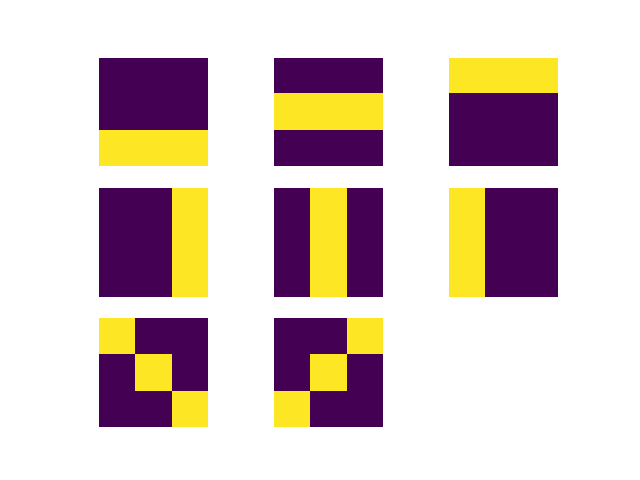

In [7]:
# plot dataset
fig, axes = plt.subplots(3,3)
to_plot = [0, 1, 2, 10, 11, 12, 20, 21]  # filter out unique patterns

for ax in axes.flatten():
    ax.set_axis_off()

for i, data in enumerate(dataset_test):
    sample, cls = data
    if i in to_plot:
        axes[i // 10, i % 10].imshow(np.array(sample)[::multiply_input_layer].reshape(3, 3))        
    
plt.show()

## Setup of network, loss and optimizer (Pytorch style)

We set up the network consisting of layers of LIF (or hardware-LIF) neurons, the loss function and the optimizer.

In [8]:
# set up Net, loss function, and optimizer
net = training.Net(network_layout, sim_params, device)

loss_function = utils.LossFunction(network_layout['layer_sizes'][-1],
                                   sim_params['tau_syn'], training_params['xi'],
                                   training_params['alpha'], training_params['beta'], device)

if training_params['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(net.parameters(), lr=training_params['learning_rate'])
elif training_params['optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(net.parameters(), lr=training_params['learning_rate'],
                                momentum=training_params['momentum'])
else:
    raise NotImplementedError(f"optimizer {training_params['optimizer']} not implemented")


Here we prepare the data structures to save recorded data during runtime.

In [9]:
# define logging variables for plots
weight_bumping_steps = []
progress_train_accuracy = np.full((training_params['epoch_number'] + 1), np.nan)
progress_val_accuracy = np.full((training_params['epoch_number'] + 1), np.nan)
progress_times_hidden = np.full(
    (training_params['epoch_number'] + 1, network_layout['layer_sizes'][0]), np.nan)
progress_times_label = np.full(
    (training_params['epoch_number'] + 1, network_layout['layer_sizes'][-1], network_layout['layer_sizes'][-1]),
    np.nan)
progress_times_label_std = np.full(
    (training_params['epoch_number'] + 1, network_layout['layer_sizes'][-1], network_layout['layer_sizes'][-1]),
    np.nan)

### Prepare validation runs and plotting

After every epoch of training we check the training progress by evaluating the performance of the network on the validation set. The results are recorded and either added to the plots immediately or saved for the final plots at the end of the training.

In [10]:
# validation function
def validate(net, loader):
    all_outputs, all_labels, all_hiddens, all_losses = [], [], [], []
    num_shown, num_correct = 0, 0
    with torch.no_grad():
        for (input_times, labels) in loader:
            outputs, hiddens = net(input_times)

            loss = loss_function(outputs, labels) * len(labels)

            firsts = outputs.argmin(1)
            # set firsts to -1 so that they cannot be counted as correct
            nan_mask = torch.isnan(torch.gather(outputs, 1, firsts.view(-1, 1))).flatten()
            inf_mask = torch.isinf(torch.gather(outputs, 1, firsts.view(-1, 1))).flatten()
            firsts[nan_mask] = -1
            firsts[inf_mask] = -1
            num_correct += len(outputs[firsts == labels])
            num_shown += len(labels)

            all_outputs.append(outputs)
            all_hiddens.append(hiddens)
            all_labels.append(labels)
            all_losses.append(loss)
        loss = sum(all_losses) / float(num_shown)  # can't use simple mean because batches might have diff size
        accuracy = float(num_correct) / num_shown
        # flatten output and label lists
        outputs = torch.stack([item for sublist in all_outputs for item in sublist])
        hiddens = torch.stack([item for sublist in all_hiddens for item in sublist])
        labels = [item.item() for sublist in all_labels for item in sublist]
        return loss, accuracy, labels, outputs, hiddens

In [11]:
# plotting function (is called once per epoch)
def evaluate_and_plot(epoch, listoffigs, print_result=lambda _: False):
    [(fig_accuracy, ax_accuracy), (fig_labeltimes, axes_labeltimes)] = listoffigs
    # ### evaluation
    loss, accuracy, labels, outputs, hiddens = validate(net, loader_val)
    # generating mean times
    unique_labels, unique_inverses = np.unique(labels, return_inverse=True)
    for i, label in enumerate(unique_labels):
        times = outputs[unique_inverses == i]
        progress_times_label[epoch + 1, i] = times.mean(axis=0)
        progress_times_label_std[epoch + 1, i] = times.std(axis=0)

    # saving data
    progress_val_accuracy[epoch + 1] = accuracy

    if debug_plotAtRuntime:
        # ### plotting
        ax_accuracy.clear()
        ax_accuracy.plot(progress_val_accuracy * 100)
        ax_accuracy.set_xlim(0, training_params['epoch_number'] + 1)
        ax_accuracy.set_ylim(-5, 105)
        ax_accuracy.set_xlabel("epochs [1]")
        ax_accuracy.set_ylabel("accuracy [%]")
        fig_accuracy.canvas.draw()

        for i_pattern, ax in enumerate(axes_labeltimes):
            ax.clear()
            ax.plot(progress_times_label[:, i_pattern])
            for i_neuron in range(len(unique_labels)):
                ax.fill_between(
                    np.arange(training_params['epoch_number'] + 1),
                    progress_times_label[:, i_pattern, i_neuron] - progress_times_label_std[:, i_pattern, i_neuron],
                    progress_times_label[:, i_pattern, i_neuron] + progress_times_label_std[:, i_pattern, i_neuron],
                                alpha=0.4)
            ax.set_ylabel("label spike times \n[$\\tau_s$]")
            ax.set_title(f"{datasets.BarsDataset.class_names[i_pattern]}. patterns") 

        axes_labeltimes[-1].set_xlim(0, training_params['epoch_number'] + 1)
        axes_labeltimes[-1].set_ylim(0.1, 2)
        axes_labeltimes[-1].set_xlabel("epochs [1]")
        fig_labeltimes.canvas.draw()
    if print_result(epoch):
        print("epoch {0}: validation accuracy: {1:.1f}%, validation loss: {2:.5f}".format(
            epoch, accuracy * 100, loss),
            flush=True)

## Actual training loop

The network is trained for the configured amount of epochs. The training is similar to an ANN in PyTorch with one crucial difference: We rely on the spike times of the neurons for learning. If the neurons do not spike, we cannot calculate gradients for these neurons. The learning can deal with some neurons being quiet for some of the stimuli but if too many neurons are quiet the learning is disrupted. To remedy that, we use an ad-hoc mechanism of bumping synaptic weights if more than a configured amount of neurons in a layer (`training_params['max_num_missing_spikes']`) do not spike.

<IPython.core.display.Javascript object>


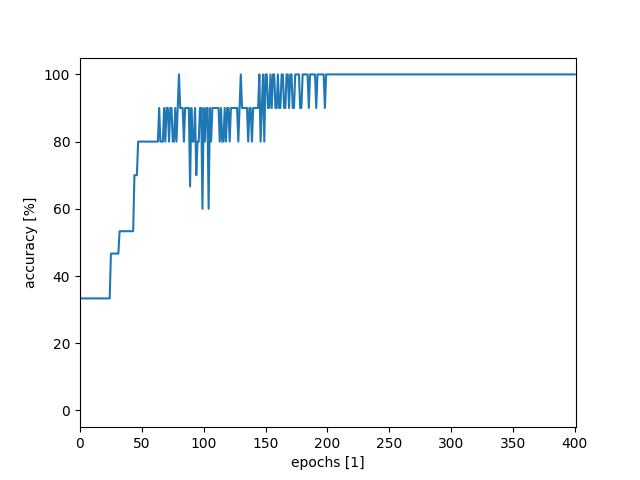

<IPython.core.display.Javascript object>


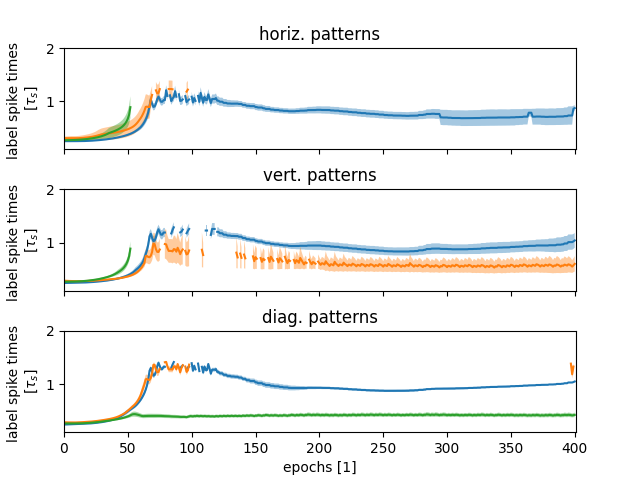

epoch 0: validation accuracy: 33.3%, validation loss: 1.10008
epoch 50: validation accuracy: 80.0%, validation loss: 0.71434
gradients too large (input size 10), chopped the following:tensor([0.2484, 0.2484, 0.2484])
gradients too large (input size 10), chopped the following:tensor([0.2409, 0.2409, 0.2409])
gradients too large (input size 10), chopped the following:tensor([0.2508, 0.2508, 0.2508])
gradients too large (input size 10), chopped the following:tensor([0.5030, 0.5030, 0.5030])
gradients too large (input size 10), chopped the following:tensor([0.3596, 0.3596, 0.2034, 0.2034, 0.3596, 0.2034])
gradients too large (input size 10), chopped the following:tensor([0.3777, 0.3777, 0.3777])
gradients too large (input size 10), chopped the following:tensor([0.2121, 0.2121, 0.2121])
gradients too large (input size 10), chopped the following:tensor([0.3614, 0.3614, 0.3614])
gradients too large (input size 10), chopped the following:tensor([0.2108, 0.2108, 0.2108])
gradients too large (in

In [12]:
# do a stunt to have the figures appear at the correct position in the notebook
fig_accuracy, ax_accuracy = plt.subplots(1, 1)
fig_labeltimes, axes_labeltimes = plt.subplots(3, 1, sharex=True, sharey=True)
fig_labeltimes.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, 
                               wspace=0.4, hspace=0.4)
fig_accuracy.show()
fig_accuracy.canvas.draw()
fig_labeltimes.show()
fig_labeltimes.canvas.draw()
plt.ioff()
listoffigs = [(fig_accuracy, ax_accuracy), (fig_labeltimes, axes_labeltimes)]

# right before training loop plot evaluation of untrained network
evaluate_and_plot(-1, listoffigs)

# training loop
for epoch in range(training_params['epoch_number']):
    train_loss = []
    num_correct = 0
    num_shown = 0
    for j, data in enumerate(loader_train):
        input_times, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        label_times, hidden_times = net(input_times)
        firsts = label_times.argmin(1)
        # Either do the backward pass or bump weights because spikes are missing
        last_weights_bumped, bump_val = training.check_bump_weights(
            net, hidden_times, label_times,
            training_params, epoch, j, bump_val, last_weights_bumped)
        if last_weights_bumped != -2:  # means bumping happened
            weight_bumping_steps.append(epoch * len(loader_train) + j)
        else:
            loss = loss_function(label_times, labels)
            loss.backward()
            optimizer.step()
            # on hardware we need extra step to write weights
            train_loss.append(loss.item())
        net.write_weights_to_hicannx()

        # set inf and nan firsts to -1 so that they cannot be counted as correct
        nan_mask = torch.isnan(torch.gather(label_times, 1, firsts.view(-1, 1))).flatten()
        inf_mask = torch.isinf(torch.gather(label_times, 1, firsts.view(-1, 1))).flatten()
        firsts[nan_mask] = -1
        firsts[inf_mask] = -1
        num_correct += len(label_times[firsts == labels])
        num_shown += len(labels)
        progress_train_accuracy[epoch] = len(label_times[firsts == labels]) / len(labels)

    # end of epoch evaluation
    train_accuracy = num_correct / num_shown if num_shown > 0 else np.nan
    evaluate_and_plot(epoch, listoffigs, print_result=debug_printIntermediateValidation)

After the training we evaluate the network performance for a final time.

In [13]:
# final evaluation
debug_plotAtRuntime = True  # to make sure the plots are printed eventually
evaluate_and_plot(epoch, listoffigs, print_result=lambda _: True)
debug_plotAtRuntime = False  # to make sure that for repeated running of the cells the interactive plotting is of

epoch 399: validation accuracy: 100.0%, validation loss: 0.05583
